# Regression lineaire

### Recuperation des donnés

On vient récuperer les données préparés et stockés dans DataMerge.csv.   
Ensuite on construit nos matrices avec une pipeline qui supprime les données incohérentes, réduit les éléments numériques à la même échelle et encode les valeurs non-numériques.


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

DATA_MERGE_PATH = os.path.join("data")
def DataMerge(data_merge_path=DATA_MERGE_PATH):
    csv_path = os.path.join(data_merge_path, "DataMerge.csv")
    return pd.read_csv(csv_path) 

X = DataMerge()


X_labels = X["Attrition"].copy()
X = X.drop("Attrition", axis=1)

#remplace gender male=1 / female=0
X.Gender.replace(to_replace=dict(Male=1, Female=0), inplace=True)
X_full_set, X_test_set, Y_full_set, Y_test_set = train_test_split(X, X_labels, test_size=0.8, random_state=42) #SOLUTION
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
 
X_num = X.select_dtypes(include=[np.number])
 
num_attribs = list(X_num)
cat_attribs = ["MaritalStatus", "JobRole", "BusinessTravel", "Department", "EducationField"]
 
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])
 
X_test_prepared = full_pipeline.fit_transform(X_test_set)
X_full_prepared = full_pipeline.fit_transform(X_full_set)



Utilisation du modèle de régression linéaire. Le modèle cherche à determiner une corréleation entre les données étiquetable et les données etiquettes à travers une fonction.
Après avoir entrainer le modèle, on test les prédictions sur quelques instances aléatoires.

In [3]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_test_prepared, Y_test_set)
# On applique le full_pipeline sur quelques instances :
some_data = X.iloc[:5]
some_labels = X_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

# Et on effectue la prédiction :
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels)) # vraies valeurs

Predictions: [0.04357974 0.29254581 0.21823917 0.01288901 0.30235911]
Labels: [0, 1, 0, 0, 0]


## Evaluation du modele

On vient calculer la fiabilité de la régression linéaire pour ensuite comparer les modèles entre eux.

In [4]:
from sklearn.metrics import mean_squared_error
from math import *
X_predictions = lin_reg.predict(X_test_prepared)
lin_rmse = sqrt(mean_squared_error(Y_test_set, X_predictions ))
lin_rmse

0.3437275531620965

# Arbre de décision

Entrainement d'un arbre de décision.

In [5]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_test_prepared, Y_test_set)
X_predictions = tree_reg.predict(X_test_prepared)
tree_mse = mean_squared_error(Y_test_set, X_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Ici l'évaluation du modèle returne 0 soit un apprentissage parfait. Or ceci est impossible en Machine Learning. On peut donc en déduire que le modèle à fait de l'overfitting.   
En effet celui ci a appri toutes les combinaison possible du jeu de données qui lui a été soumis pour le fitting. 

# Cross Validation

La cross-validation permet d'evaluer la fiabilité du model en testant des échantillons du jeu de données.

## Arbre de decision

In [6]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_test_prepared, Y_test_set,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
#Calcul du score avec le jeu de validation
new_scores = cross_val_score(tree_reg, X_full_prepared, Y_full_set,
                         scoring="neg_mean_squared_error", cv=10)
new_tree_rmse_scores = np.sqrt(-new_scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)
display_scores(new_tree_rmse_scores)

Scores: [0.23501608 0.27492071 0.27492071 0.17882042 0.21566555 0.26413527
 0.23501608 0.24707592 0.29034863 0.25289027]
Mean: 0.2468809638564653
Standard deviation: 0.031119034953955408
Scores: [0.43133109 0.44460591 0.45749571 0.47003216 0.44460591 0.47003216
 0.43133109 0.45749571 0.49415185 0.43133109]
Mean: 0.4532412696071809
Standard deviation: 0.01965464355420423


On voit ici que la fiabilité n'est plus a 0. Donc le modèle n'est pas assez performant sur un jeu de donné inconnu.

## Regression Lineaire


In [7]:
scores = cross_val_score(lin_reg, X_test_prepared, Y_test_set,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [0.33465968 0.33240475 0.37284842 0.32991516 0.33355488 0.32199852
 0.36119033 0.36038367 0.3699375  0.34570255]
Mean: 0.3462595458753298
Standard deviation: 0.017418379453167095


# Foret Aléatoire

In [8]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_test_prepared, Y_test_set)
X_predictions = forest_reg.predict(X_test_prepared)
forest_rmse = mean_squared_error(Y_test_set, X_predictions)
forest_rmse = np.sqrt(forest_rmse)
forest_rmse

0.0890192035723257

In [9]:
forest_scores = cross_val_score(forest_reg, X_test_prepared, Y_test_set,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.20324404 0.23259157 0.22938239 0.18677184 0.19199079 0.1768589
 0.2342107  0.23674144 0.23020466 0.1996363 ]
Mean: 0.2121632628353299
Standard deviation: 0.02159632065555168


## Support Vector Regression 

In [10]:
from sklearn.svm import SVR
svr_regr = SVR(kernel="linear")
svr_regr.fit(X_test_prepared, Y_test_set)
X_predictions = svr_regr.predict(X_test_prepared)
svr_mse = mean_squared_error(Y_test_set, X_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

0.3728904196607226

In [11]:
svr_regr_scores = cross_val_score(svr_regr, X_test_prepared, Y_test_set,
                                scoring="neg_mean_squared_error", cv=10)
svr_regr_rmse_scores = np.sqrt(-svr_regr_scores)
display_scores(svr_regr_rmse_scores)

Scores: [0.34871446 0.35857218 0.41001831 0.36815984 0.35532436 0.32454261
 0.39559787 0.3955853  0.40716693 0.35531165]
Mean: 0.3718993498620441
Standard deviation: 0.02709461442729581


## Grid Search

Recherche des meilleurs paramètres.


In [12]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # essaye 12 (3×4) combinaisons des hyperparametres
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # puis essaye 6 (2×3) combinaisons avec bootstrap à False (True étant la valeur par défaut)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

# 5 sous-jeux de cross-val, ça fait en tout (12+6)*5=90 tours d'entraînement 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_test_prepared, Y_test_set)
grid_search.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

Affichage de la cross validation avec les meilleurs paramètres determiné par la grid search

In [13]:
cv_res = grid_search.cv_results_
forest_predicted = RandomForestRegressor(max_features=3, n_estimators=10, random_state=42)
forest_predicted.fit(X_test_prepared, Y_test_set)
forest_scores = cross_val_score(forest_predicted, X_test_prepared, Y_test_set,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.19795466 0.20636669 0.21640563 0.17151853 0.17504152 0.18552252
 0.21261112 0.21185778 0.20573182 0.19484639]
Mean: 0.19778566533660935
Standard deviation: 0.015058579611401082


Les résultats montrent une légère amélioration de la fiabilité grâce aux nouveaux hyperparamètres 

## Randomized Search

Recherche des meilleurs parametres avec une grille aléatoire

In [14]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=20),
    }

random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True, random_state=42)
random_search.fit(X_test_prepared, Y_test_set)
random_srch = random_search.cv_results_

for mean_score, param in zip(random_srch['mean_test_score'], random_srch['params']):
    print(np.sqrt(-mean_score), param)

    #Sort  the result

0.1997390542155595 {'max_features': 7, 'n_estimators': 180}
0.2061811561603739 {'max_features': 15, 'n_estimators': 107}
0.19834308282026414 {'max_features': 8, 'n_estimators': 189}
0.20089823947231547 {'max_features': 7, 'n_estimators': 122}
0.20806106239456368 {'max_features': 19, 'n_estimators': 75}
0.20383527906791926 {'max_features': 11, 'n_estimators': 88}
0.1971500144108376 {'max_features': 4, 'n_estimators': 104}
0.19466216677394352 {'max_features': 3, 'n_estimators': 150}
0.1943673013533486 {'max_features': 2, 'n_estimators': 88}
0.20331904062740502 {'max_features': 12, 'n_estimators': 158}


## Importance de chaque attribut

In [15]:
feature_importances = random_search.best_estimator_.feature_importances_
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.07643581117998811, 'MeanWorkingTime'),
 (0.07323570482539525, 'Age'),
 (0.06549139530591457, 'TotalWorkingYears'),
 (0.06171282078992841, 'MonthlyIncome'),
 (0.0584762774732892, 'YearsAtCompany'),
 (0.04802713593767167, 'DistanceFromHome'),
 (0.04771630039496903, 'PercentSalaryHike'),
 (0.04468606891057494, 'NumCompaniesWorked'),
 (0.044355824635589375, 'YearsWithCurrManager'),
 (0.03820293717257646, 'Married'),
 (0.03605800163153158, 'EnvironmentSatisfaction'),
 (0.03547613988473491, 'Unnamed: 0'),
 (0.03395832325845624, 'JobSatisfaction'),
 (0.03376526879775789, 'YearsSinceLastPromotion'),
 (0.03196689422977125, 'WorkLifeBalance'),
 (0.031900228185072474, 'TrainingTimesLastYear'),
 (0.030595610512323325, 'Divorced'),
 (0.0300497940705089, 'Education'),
 (0.027256915815805458, 'JobLevel'),
 (0.025398690055545178, 'JobInvolvement'),
 (0.02421166834994116, 'StockOptionLevel'),
 (0.021067676560164214, 'Single'),
 (0.016956106769926704, 'Gender'),
 (0.01026378430103669, 'PerformanceRa

On peut voir que StandardHours, Over18 et EmployeeCount n'ont pas d'influence sur le model. On peut donc les drop pour optimiser l'efficacité des models

# Evaluation avec le meilleur modèle

On évalue maintenant le reste du jeu de donné avec le modèle le plus performant

In [16]:
from statistics import mean
final_model = random_search.best_estimator_
X_full_prepared = full_pipeline.transform(X_full_set)
X_predictions = final_model.predict(X_full_prepared)

final_mse = mean_squared_error(Y_full_set, X_predictions)
final_rmse = np.sqrt(final_mse)
print(mean(X_predictions))

0.1622225158562368


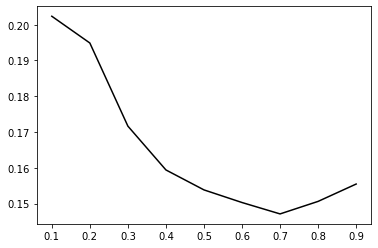

In [44]:
import matplotlib.pyplot as plt
def newPrediction(attribut, coef): 
    X2 = DataMerge()
    X2[attribut] = X2[attribut] * coef
    X2_labels = X2["Attrition"].copy()
    X2 = X2.drop("Attrition", axis=1)
    X2.Gender.replace(to_replace=dict(Male=1, Female=0), inplace=True)
    X2_full_set, X2_test_set, Y2_full_set, Y2_test_set = train_test_split(X2, X2_labels, test_size=0.8, random_state=42) #SOLUTION
    X2_full_prepared = full_pipeline.transform(X2_full_set)
    X2_predictions = final_model.predict(X2_full_prepared)
    return np.mean(X2_predictions)
coefArray = np.arange(0.1, 1.0, 0.1)

y =[]
for i in coefArray:
    iStr = str(i)
    # print('Moyenne d\'attrition : ' + newPrediction('MeanWorkingTime', i) + ', coef :' + iStr)
    y.append(newPrediction('MeanWorkingTime', i))

plt.plot(coefArray, np.array(y), 'k')
plt.show()

Le meilleur résultat de fiabilité que l'on peut obtenir avec le jeu de validation.